# fitting real Kepler light curves

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import scipy
from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
nwalk = 64
nsteps_d = 1500
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [3]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [6]:
spectplanets = pd.read_csv('datafiles2/spectplanets.csv')
muirhead_comb = pd.read_csv('datafiles2/muirhead_comb.csv')
muirhead_comb_lums = pd.read_csv('datafiles2/muirhead_comb_lums.csv')
muirhead_lamost = pd.read_csv('datafiles2/muirhead_lamost.csv')

In [7]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

In [8]:
strkois = [str(i) for i in KOIs]

In [9]:
strkois = ['KOI ' + i for i in strkois]

In [10]:
# Some of these are false positives, e.g. KOI 961

# KOIs

In [11]:
#np.savetxt('MuirheadKOIs.txt', strkois, fmt='%s')

In [12]:
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/sample_LCs/'
lclist = []

for i in range(len(KICs)):
    templst = []
    for subdir, dirs, files in os.walk(lcpath):
        for file in files:
            if str(KICs[i]) in file:
                templst.append(os.path.join(subdir, file))
    lclist.append(templst)

In [13]:
def get_stitched_lcs(KOI):
    
    files = lclist[int(np.argwhere(KOIs==KOI))]
    
    time = []
    flux = []
    flux_err = []
    
    for file in files:
        hdu = fits.open(file)
        time.append(list(hdu[1].data['TIME'] + hdu[1].header['BJDREFI']))
        flux_p = hdu[1].data['PDCSAP_FLUX']
        flux_err_p = hdu[1].data['PDCSAP_FLUX_ERR']
        
        fmed = np.nanmedian(flux_p)
    
        
        flux.append(list(flux_p/fmed))
        flux_err.append(list(flux_err_p/fmed))


        #hdu.close()
    
    return hdu, time, flux, flux_err

In [19]:
hdu, t, f, fe = get_stitched_lcs('898')

In [20]:
#plt.errorbar(t[0], f[0], yerr=fe[0], fmt='o')

In [21]:
alltime_noclip = []
allflux_noclip = []
allfluxerr_noclip = []

for sublist in t:
    for item in sublist:
        alltime_noclip.append(item)
        
for sublist in f:
    for item in sublist:
        allflux_noclip.append(item)
        
for sublist in fe:
    for item in sublist:
        allfluxerr_noclip.append(item)

In [22]:
def sigma_clip(time, flux, fluxerr, sig=4):
    for i in tqdm(range(len(flux))):
        if flux[i] > np.nanmean(flux) + sig*np.nanstd(flux) or flux[i] < np.nanmean(flux) - sig*np.nanstd(flux):
            time[i] = np.nan
            flux[i] = np.nan
            fluxerr[i] = np.nan
            
    return time, flux, fluxerr
            

Text(0.5, 1.0, 'KOI 898')

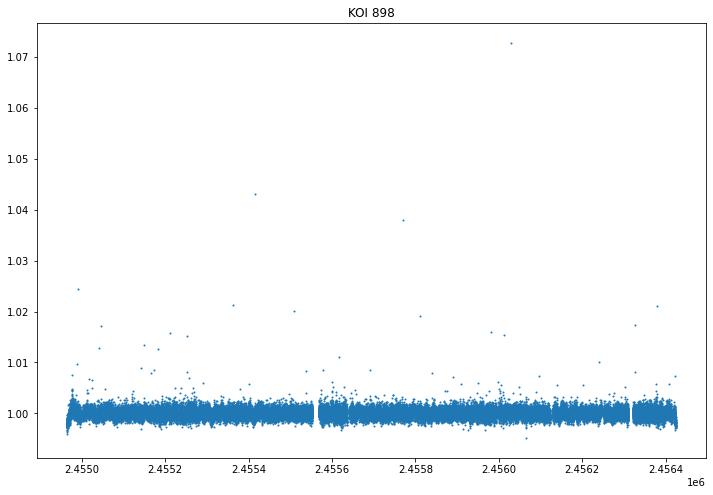

In [24]:
# alltime, allflux, allfluxerr = sigma_clip(alltime_noclip, allflux_noclip, allfluxerr_noclip, sig=4)

alltime, allflux, allfluxerr = alltime_noclip, allflux_noclip, allfluxerr_noclip

plt.scatter(alltime, allflux, s=1)
plt.title('KOI 898')

# Kepler- b

In [27]:
#midpoints = np.unique(list(midjd[midjd['planetname'] == 'Kepler-83 b']['midpointjd']))
#midpoints_errs = np.unique(list(midjd[midjd['username'] == 'KOI ' + '947']['propmidpointunc']))

In [29]:
#len(midpoints)

In [30]:
cmtimes = []
cmerrors = []

for j in range(len(midpoints)):
    if np.nanmin(alltime) < midpoints[j] < np.nanmax(alltime):
        cmtimes.append(midpoints[j])
        cmerrors.append(midpoints_errs[j])

NameError: name 'midpoints' is not defined

In [20]:
def get_KIC(KOI, muirhead_comb):
    return muirhead_comb[muirhead_comb['KOI'] == str(KOI)].KIC.item()

In [175]:
def fit_Kepler_lc(KOI, time, flux, flux_err, period, nbuffer, midjd_path, spectplanets, muirhead_comb):
    
    # Get alt IDs
    kepid = get_KIC(KOI, muirhead_comb)
    kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]
    
    dr = str(KOI)
    direct = 'segfits/' + dr + '/'

    if not os.path.exists(direct):
        os.mkdir(direct)
    
    # Get stellar params
    isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")
    
    mstar = isodf["mstar"].mean()
    mstar_err = isodf["mstar"].std()

    rstar = isodf["radius"].mean()
    rstar_err = isodf["radius"].std()
    
    # Get planet params
    period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

    # We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
    a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
    a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

    print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
    print('Period (Days): ', period, 'Rp/Rs: ', rprs)
    print('a/Rs: ', a_rs)
    print('i (deg): ', i)
    
    
    midpoints = np.unique(list(midjd[midjd['planetname'] == 'Kepler-737 b']['midpointjd']))
    
    cmtimes = []

    for j in range(len(midpoints)):
        if np.nanmin(time) < midpoints[j] < np.nanmax(time):
            cmtimes.append(midpoints[j])
            
    
    for ind in range(len(cmerrors)):

        try:
        
            transitmid = cmtimes[ind]

            tindex = int(np.where(alltime == ph.find_nearest(alltime, transitmid))[0])

            t1 = np.array(time[tindex-nbuffer:tindex+nbuffer]) - transitmid
            f1 = np.array(flux[tindex-nbuffer:tindex+nbuffer])
            fe1 = np.array(flux_err[tindex-nbuffer:tindex+nbuffer])

            tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

            idx = np.isfinite(t1) & np.isfinite(f1)

            disc = 4
            m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

            linfit = m*t1 + b
            fnorm = (f1-linfit)+1
            
            plt.cla()
            plt.errorbar(t1, f1, yerr=fe1, fmt='o', c='blue')
            plt.plot(t1, linfit, c='green')
            plt.xlabel('Time')
            plt.ylabel('Rel. Flux')
            plt.axvline(0, c='r')
            plt.savefig(direct + str(KOI) + 'segment' + str(ind) + '.png')

            mid = ph.get_mid(time)
            ptime = ph.get_ptime(t1, mid, 29)

            fnorm = np.nan_to_num(fnorm, nan=1.0)
            fe1 = np.nan_to_num(fe1, nan=np.nanmedian(fe1))


            # Inital guess: rprs, a/Rs, i, w
            p0 = [rprs, a_rs, i, 0]

            # EMCEE Transit Model Fitting
            _, _, rdist, adist, idist, t0dist = ph.mcmc_fitter_noper(p0, period, t1, ptime, fnorm, fe1, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct, plot_Tburnin=False, plot_Tcorner=False)
            
            # Create a light curve with the fit parameters
            mcmcfit = ph.integratedlc_fitter(t1, period, ph.mode(rdist), ph.mode(adist), ph.mode(idist), ph.mode(t0dist))
            truefit = ph.integratedlc_fitter(t1, period, rprs, a_rs, i, 0)

            plt.cla()
            plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
            plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
            plt.plot(t1, mcmcfit, c='red', alpha=1.0)
            plt.plot(t1, truefit, c='green', alpha=1.0)
            
            textstr = '\n'.join((
            r'$\mathrm{Rp/Rs}=%.2f$' % (ph.mode(rdist), ),
            r'$\mathrm{a_rs}=%.2f$' % (ph.mode(adist), ),
            r'$\mathrm{i}=%.2f$' % (ph.mode(idist), ),
            r'$\mathrm{t0}=%.2f$' % (ph.mode(t0dist), )))
            plt.title(textstr)

            plt.legend()
            
            plt.savefig(direct + str(KOI) + 'segment' + str(ind) + 'fit.png')
            
            
        # Skip if transit mid-time falls outside of Kepler observations
        except TypeError:
            continue



In [176]:
midjd = pd.read_csv('/Users/ssagear/Downloads/transits_2021.06.18_12.57.01.csv', comment='#')

period = 28.59915399

Stellar mass (Msun):  0.48797798116154106 Stellar radius (Rsun):  0.4690682721275218
Period (Days):  28.59914031 Rp/Rs:  0.036375
a/Rs:  65.99499728728715
i (deg):  89.99


 21%|██▏       | 321/1500 [00:11<00:34, 33.76it/s]Traceback (most recent call last):
  File "/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py", line 975, in tfit_noper_log_probability
    return lp + tfit_noper_log_likelihood(theta, per, time, ptime, flux, flux_err)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py", line 949, in tfit_noper_log_likelihood
    model = integratedlc_fitter(time, per, rp, a, inc, t0)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/lcfitter.py", line 164, in integratedlc_fitter
    ptime = get_ptime(time, get_mid(time), 29)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/lcfitter.py", line 271, in ge

emcee: Exception while calling your likelihood function:
  params: [ 0.8886676  26.15280519  3.58338743  0.19263593]
  args: (28.59914031, array([-0.18642636, -0.16599303, -0.14555959, -0.12512636, -0.10469292,
       -0.08425959, -0.06382635, -0.04339291, -0.02295958, -0.00252624,
        0.0179071 ,  0.03834043,  0.05877377,  0.07920711,  0.09964045,
        0.12007379,  0.14050712,  0.16094046]), array([-0.19664346, -0.19591366, -0.19518387, -0.19445408, -0.19372429,
       -0.19299449, -0.1922647 , -0.19153491, -0.19080512, -0.19007533,
       -0.18934553, -0.18861574, -0.18788595, -0.18715616, -0.18642636,
       -0.18569657, -0.18496678, -0.18423699, -0.1835072 , -0.1827774 ,
       -0.18204761, -0.18131782, -0.18058803, -0.17985823, -0.17912844,
       -0.17839865, -0.17766886, -0.17693907, -0.17620927, -0.17621012,
       -0.17548033, -0.17475054, -0.17402074, -0.17329095, -0.17256116,
       -0.17183137, -0.17110157, -0.17037178, -0.16964199, -0.1689122 ,
       -0.16818241, -

KeyboardInterrupt: 

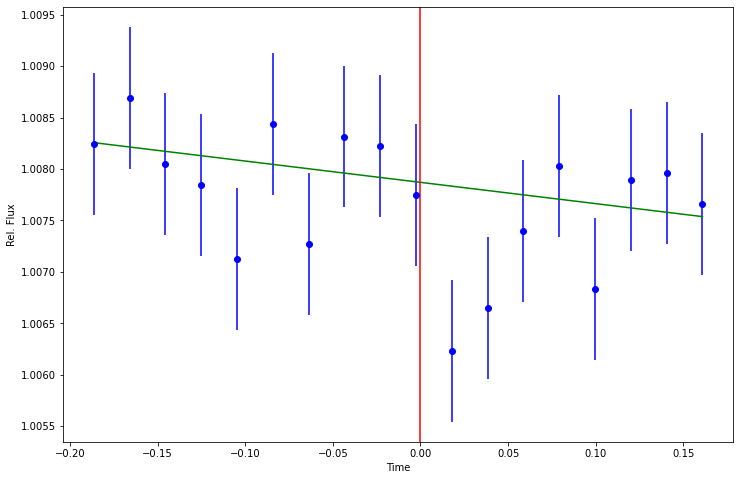

In [177]:
fit_Kepler_lc(947, alltime, allflux, allfluxerr, period, 9, midjd, spectplanets, muirhead_comb)

In [46]:
period = 28.59915399

t0 = hdu[1].header['BJDREFI']
tm1 = hdu[1].header['BJDREFI']+period*100
tmidtimes = np.arange(t0, tm1, period)

In [47]:
midjd = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/keplerstellar/transitmpts/MuirheadKOIs_4_MPTS.csv', comment='#')


In [48]:
midpoints = [item for item in midjd[midjd['username'] == 'KOI 947']['midpointjd']]
midpoints_errs = [item for item in midjd[midjd['username'] == 'KOI 947']['propmidpointunc']]

In [49]:
cmtimes = []
cmerrors = []

for j in range(len(midpoints)):
    if alltime[0] < midpoints[j] < alltime[-1]:
        cmtimes.append(midpoints[j])
        cmerrors.append(midpoints_errs[j])

In [50]:
#cmtimes[6] = cmtimes[6] + 0.017
#cmtimes[-6] = cmtimes[-6] - 0.017

mp = 1

transitmid = cmtimes[mp]
transitmid_err = cmerrors[mp]

transitmid = cmtimes[mp]

In [51]:
start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI']
end = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI']

In [52]:
mid = ph.get_mid(alltime)

In [53]:
tindex = int(np.where(alltime == ph.find_nearest(alltime, transitmid))[0])

In [54]:
n = 6

t1 = np.array(alltime[tindex-n:tindex+n]) - transitmid
f1 = np.array(allflux[tindex-n:tindex+n])
fe1 = np.array(allfluxerr[tindex-n:tindex+n])

In [55]:
# plt.errorbar(alltime, allflux, yerr=allfluxerr, fmt='o')
# plt.axvline(cmtimes[5], c='r')
# plt.axvline(cmtimes[6], c='r')
# plt.xlim(cmtimes[5]-3, cmtimes[6]+3)
# plt.ylim(.990, 1.010)

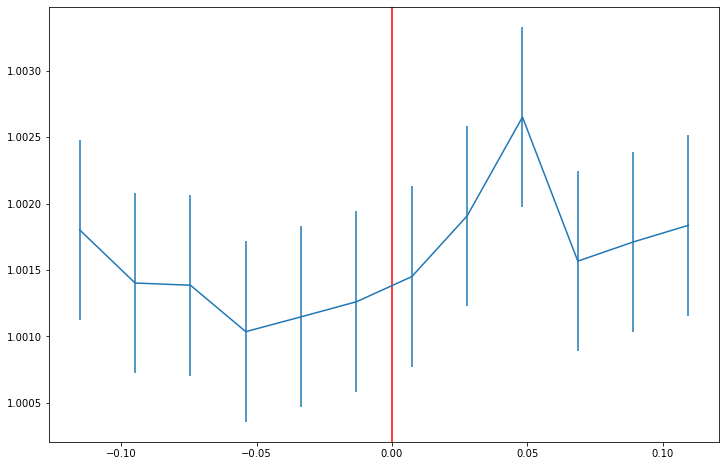

In [56]:
plt.errorbar(t1, f1, yerr=fe1)
#plt.axvline(0+transitmid_err, c='r')
#plt.axvline(0-transitmid_err, c='r')
plt.axvline(0, c='r')


[ True  True  True  True  True  True  True  True  True  True  True  True]


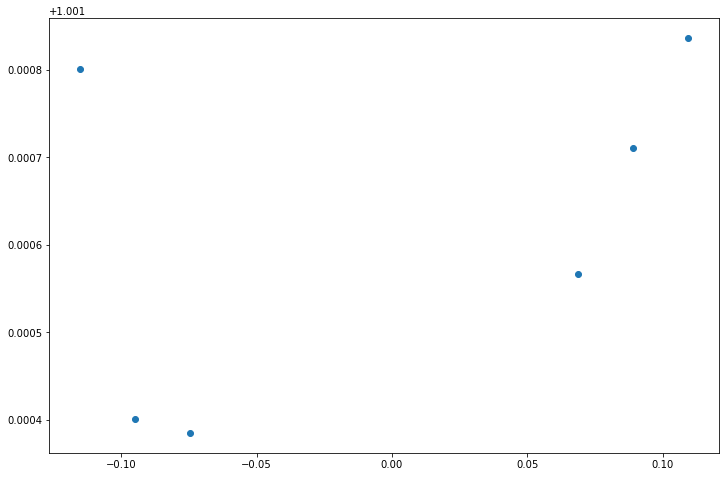

In [73]:
idx = np.isfinite(t1) & np.isfinite(f1)
print(idx)
disc = 3

a, b, c = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 2)
m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)


plt.scatter(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])))

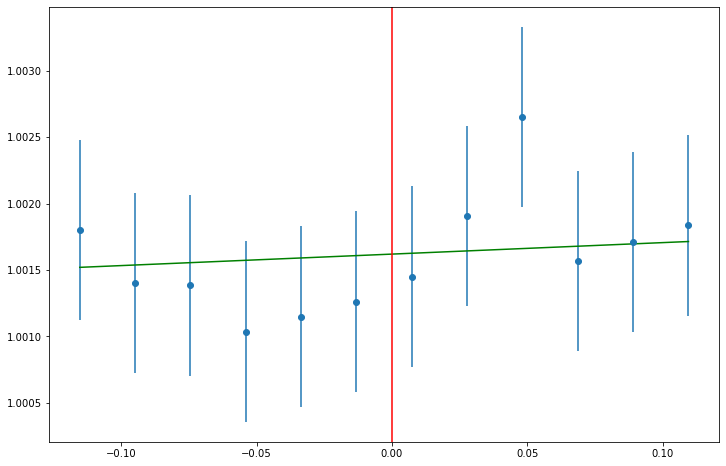

In [65]:
plt.plot(t1, m*t1 + b, c='g')
#plt.plot(t1, a*t1**2 + b*t1 + c, c='g')
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [66]:
linfit = m*t1 + b
fnorm = (f1-linfit)+1

#quadfit = a*t1**2 + b*t1 + c
#fnorm = (f1-quadfit)+1

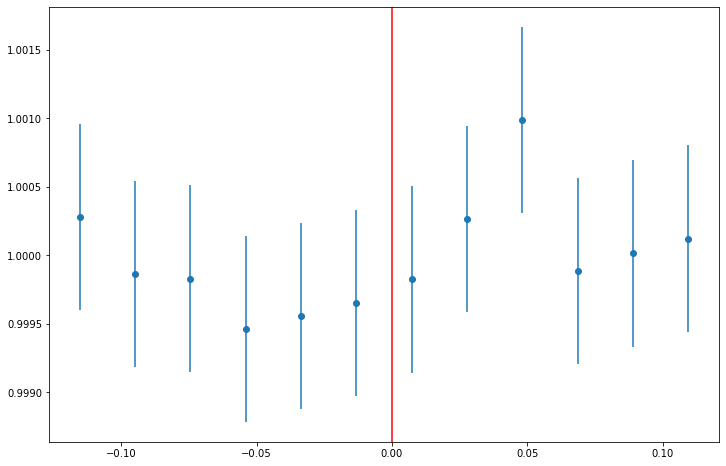

In [67]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [68]:
mid

0.01021709106862545

In [69]:
ptime = ph.get_ptime(t1, mid, 29)
fnorm = np.nan_to_num(fnorm, nan=1.0)
fe1 = np.nan_to_num(fe1, nan=np.nanmedian(fe1))

In [70]:
#fnorm[np.argmax(fnorm)] = np.nanmedian(fnorm)

In [71]:
#fe1 = fe1/4

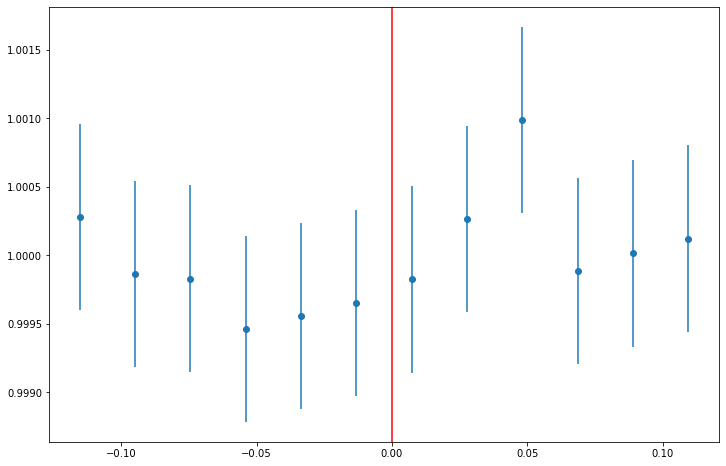

In [72]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [40]:
# Inital guess: rprs, a/Rs, i, w
p0 = [0.037493, 61, 89.99, 0]

dr = 'Kepler737b'
direct = 'plots/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, rdist, adist, idist, t0dist = ph.mcmc_fitter_noper(p0, period, t1, ptime, fnorm, fe1, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct)

  8%|▊         | 123/1500 [00:03<00:30, 45.72it/s]Traceback (most recent call last):
  File "/Users/ssagear/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py", line 973, in tfit_noper_log_probability
    return lp + tfit_noper_log_likelihood(theta, per, time, ptime, flux, flux_err)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py", line 948, in tfit_noper_log_likelihood
    model = integratedlc_fitter(time, per, rp, a, inc, t0)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/lcfitter.py", line 164, in integratedlc_fitter
    ptime = get_ptime(time, get_mid(time), 29)
  File "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/lcfitter.py", line 271, in ge

emcee: Exception while calling your likelihood function:
  params: [   0.54895355  125.55668043   49.28103601 -226.9785562 ]
  args: (28.59915399, array([-0.12571831, -0.10528542, -0.08485254, -0.06441965, -0.04398676,
       -0.02355387, -0.00312098,  0.01731191,  0.0377448 ,  0.05817768,
        0.07861057,  0.09904346]), array([-0.1359354 , -0.13520561, -0.13447582, -0.13374603, -0.13301623,
       -0.13228644, -0.13155665, -0.13082686, -0.13009707, -0.12936727,
       -0.12863748, -0.12790769, -0.1271779 , -0.12644811, -0.12571831,
       -0.12498852, -0.12425873, -0.12352894, -0.12279914, -0.12206935,
       -0.12133956, -0.12060977, -0.11987998, -0.11915018, -0.11842039,
       -0.1176906 , -0.11696081, -0.11623101, -0.11550122, -0.11550252,
       -0.11477272, -0.11404293, -0.11331314, -0.11258335, -0.11185355,
       -0.11112376, -0.11039397, -0.10966418, -0.10893439, -0.10820459,
       -0.1074748 , -0.10674501, -0.10601522, -0.10528542, -0.10455563,
       -0.10382584, -0.103

KeyboardInterrupt: 

In [1134]:
ph.mode(rdist)

0.989835250918609

In [1135]:
ph.mode(adist)

138824040095800.0

In [1136]:
ph.mode(idist)

0.9159162961717467

In [1137]:
ph.mode(t0dist)

-5.653595704209818e+31

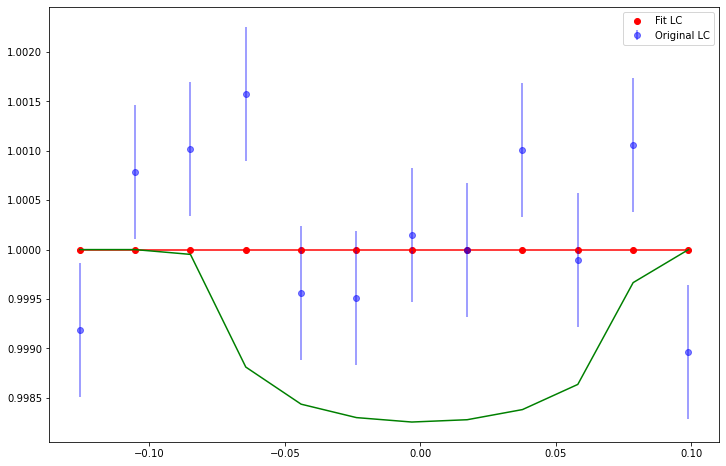

In [1138]:
# Create a light curve with the fit parameters

mcmcfit = ph.integratedlc_fitter(t1, period, ph.mode(rdist), ph.mode(adist), ph.mode(idist), ph.mode(t0dist))
truefit = ph.integratedlc_fitter(t1, period, 0.037451, 60, 89.9, 0)

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)
plt.plot(t1, truefit, c='green', alpha=1.0)

plt.legend()